# Sync to Github

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')


In [ ]:
#!git clone https://github.com/zk-qmy/dl-stock-prediction.git

In [ ]:
#%pwd


In [ ]:
#%cd /content/dl-stock-prediction/src/models/nasdag


In [ ]:
# pull to get the update files from git
#!git pull origin main
#!ls

In [ ]:
#!mv /content/drive/MyDrive/ColabNotebooks/DeepLearning/DeepLearningforAI/FinalProject/nasdag_model.ipynb /content/dl-stock-prediction/src/models/nasdag


In [ ]:
#!ls

In [ ]:
#!git add .  # Replace with your notebook filename

# Load data

In [1]:
!pip install scikeras

In [2]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import tensorflow as tf
from tensorflow import keras
# Import KerasRegressor from scikeras
from scikeras.wrappers import KerasRegressor # Changed import statement to use scikeras

In [ ]:
# Load data from csv file
data = pd.read_csv('nasdag_selected.csv')
data_nasdag = data.copy()
data_nasdag.head()

,Date,Ticker,Low,Open,Volume,High,Close,AdjustedClose
0,1970-01-02,GT,15.125,15.3750,64600,15.8750,15.7500,3.40241
1,1970-01-05,GT,15.250,15.6875,47200,15.6875,15.4375,3.33490
2,1970-01-06,GT,14.750,15.1875,122000,15.1875,15.0000,3.24039
3,1970-01-07,GT,14.625,14.9375,45600,14.9375,14.8125,3.19989
4,1970-01-08,GT,14.625,14.8125,50400,14.9375,14.7500,3.18639


# Preprocess data

## Get data samples with Window

In [ ]:
### Split the dataset into time windows to get data samples.
'''Predict "Open" for the next day based on multi-feature'''

df = data_nasdag

X_data = []
y_data = []
window_size=30 # Time window for data feature (size of 'number of days').

# Get the low, open, volume, high, close, adjustedclose
for i in range(0, len(df) - window_size - 1):
    data_feature = []
    data_label = []

    # Get a window_size time frame for data feature
    for j in range(window_size):
        data_feature.append(df.iloc[i + j, 2:].to_numpy().tolist())

    # Next value is the label (price of the next day) to be predicted
    data_label.append(df.iloc[i + window_size, 3]) # Number 3 is the "Open" column


    # Append new data sample (feature and label) to X_data and y_data
    X_data.append(np.array(data_feature).reshape(window_size, 6))
    y_data.append(np.array(data_label))


## Split data into Train/Val/Test sets


In [ ]:
# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [ ]:
# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 6)
X_val = X_val.reshape(X_val.shape[0], window_size, 6)
X_test = X_test.reshape(X_test.shape[0], window_size, 6)

# Print shape of the training, validation and test set
print("Shape of training set: ", X_train.shape)
print("Shape of validation set: ", X_val.shape)
print("Shape of test set: ", X_test.shape)

Shape of training set:  (8528, 30, 6)
Shape of validation set:  (2132, 30, 6)
Shape of test set:  (2665, 30, 6)


## Normalise data using MinMaxScaler

In [ ]:
# Initialize the MinMaxScaler for each feature
y_scaler = MinMaxScaler()
X_scalers = []
# Reshape each feature (axis=-1) for scaling
X_train_norm = X_train.copy()
X_val_norm = X_val.copy()
X_test_norm = X_test.copy()

# Loop through each feature (axis=2) and scale across time and samples
for i in range(X_train.shape[2]):
    x_scaler = MinMaxScaler()
    # Flatten the data for the i-th feature and apply MinMaxScaler
    X_train_norm[:, :, i] = x_scaler.fit_transform(X_train[:, :, i])
    X_val_norm[:, :, i] = x_scaler.transform(X_val[:, :, i])
    X_test_norm[:, :, i] = x_scaler.transform(X_test[:, :, i])
    X_scalers.append(x_scaler)

    y_train_norm = y_scaler.fit_transform(y_train)
    y_val_norm = y_scaler.transform(y_val)
    y_test_norm = y_scaler.transform(y_test)

# Check the new shapes (they should remain the same as before)
print("Shape of scaled training set: ", X_train_norm.shape)
print("Shape of scaled validation set: ", X_val_norm.shape)
print("Shape of scaled test set: ", X_test_norm.shape)


Shape of scaled training set:  (8528, 30, 6)
Shape of scaled validation set:  (2132, 30, 6)
Shape of scaled test set:  (2665, 30, 6)


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomMinMaxScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.x_scalers = []
        self.y_scaler_ = MinMaxScaler()  # One scaler for y

    def fit(self, X, y=None):
        self.x_scalers = []  # Initialize list to store scalers for each feature

        # Create a scaler for each feature (axis=2) without reshaping
        for i in range(X.shape[2]):
            scaler = MinMaxScaler()
            # Fit the scaler to the i-th feature
            scaler.fit(X[:, :, i])
            self.x_scalers.append(scaler)

        # Fit the scaler for y, if y is provided
        if y is not None:
            self.y_scaler_.fit(y)
        return self

    def transform(self, X):
        X_scaled = np.zeros_like(X)  # Initialize scaled array

        # Apply the fitted scaler to each feature (without reshaping)
        for i in range(X.shape[2]):
            X_scaled[:, :, i] = self.x_scalers[i].transform(X[:, :, i])
        return X_scaled

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

    def inverse_transform(self, X):
        X_inv = np.zeros_like(X)  # Initialize inverse scaled array

        # Apply inverse transform to each feature (without reshaping)
        for i in range(X.shape[2]):
            X_inv[:, :, i] = self.x_scalers[i].inverse_transform(X[:, :, i])

        return X_inv

    def transform_y(self, y):
        # Transform y (if provided)
        return self.y_scaler_.transform(y)

    def inverse_transform_y(self, y):
        # Inverse transform y (if provided)
        return self.y_scaler_.inverse_transform(y)


# Task 1.1: Predict 1 day ahead

###a. Train with time series data

#### 1D Convolutional layer

In [ ]:
### Create and train the model_1d
from tensorflow.keras.layers import Input  # Importing Input from tensorflow.keras.layers
def create_model_1d():
  model_1d = tf.keras.Sequential()
  model_1d.add(Input(shape=(window_size, 6)))
  #model_1d.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size,6), padding='same'))
  model_1d.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
  model_1d.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))

  model_1d.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
  model_1d.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
  model_1d.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
  model_1d.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
  model_1d.add(MaxPooling1D(pool_size=2))

  model_1d.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
  model_1d.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
  model_1d.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
  model_1d.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
  model_1d.add(MaxPooling1D(2))

  model_1d.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
  model_1d.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
  model_1d.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
  model_1d.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
  model_1d.add(MaxPooling1D(2))

  model_1d.add(Flatten())
  model_1d.add(Dense(100, activation='relu'))
  model_1d.add(Dense(1, activation='linear')) # By default: activation='linear', i.e., passing through f(x) = x

  #model_1d.summary()
  model_1d.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
  return model_1d

In [ ]:
model = KerasRegressor(model=create_model_1d(), batch_size=512, epochs=20, verbose=0)

# Pass validation_data to the fit method
history = model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm, y_val_norm), verbose=0).history_

In [ ]:
losses = history["mean_absolute_error"]
val_losses = history["val_mean_absolute_error"]

In [ ]:
print(losses)
print(val_losses)

[0.15477588772773743, 0.05641143023967743, 0.025409376248717308, 0.017153039574623108, 0.01574319414794445, 0.014929741621017456, 0.013776351697742939, 0.013016455806791782, 0.01309667993336916, 0.01034865528345108, 0.009820904582738876, 0.009441955015063286, 0.007699656765908003, 0.006440779659897089, 0.006637197453528643, 0.006454824469983578, 0.004971759859472513, 0.008440413512289524, 0.006963042076677084, 0.007352260407060385]
[]


In [ ]:
# Create a callback ModelCheckpoint
mc =keras.callbacks.ModelCheckpoint(filepath="/content/model_1d.keras",  # Path to save the model
                     monitor='val_loss',  # Metric to evaluate the model performance
                     mode='min',  # 'min' because we want to minimize the loss
                     verbose=0,  # Output log
                     save_best_only=True)  # Only save the best model
model = KerasRegressor(model=create_model_1d, epochs=20, batch_size=512, verbose=0)
# Create a pipeline with the custom scaler and the model wrapped in KerasRegressor
pipeline = Pipeline([
    ('scaler', CustomMinMaxScaler()),  # Your custom scaler
    ('model', model)  # Wrap your model creation function
])

In [ ]:
# Fit the pipeline on normalized training data and capture history
history = pipeline.fit(
    X_train,
    y_train,
    model__validation_data=(X_val, y_val),
    model__callbacks=[mc])  # Pass validation data and callbacks

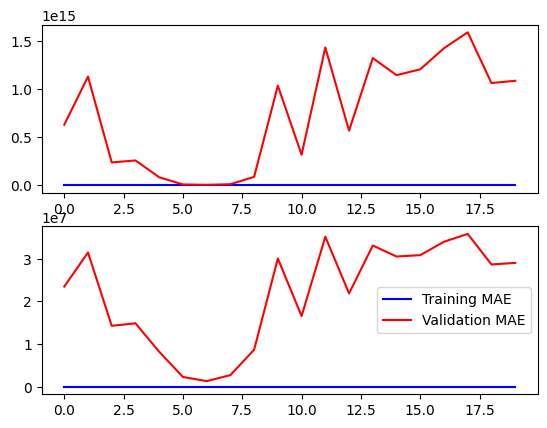

In [ ]:
# Access history from the 'model' step in the pipeline
model_history = history.named_steps['model'].model_.history.history

# Visualize training and validation performance
f,ax=plt.subplots(2,1)

# Plot training and validation loss
ax[0].plot(model_history['loss'], color='b',label='Training Loss')
ax[0].plot(model_history['val_loss'],color='r',label='Validation Loss')

# Plot training and validation accuracy
ax[1].plot(model_history['mae'],color='b',label='Training MAE')
ax[1].plot(model_history['val_mae'],color='r',label='Validation MAE')

plt.legend()

In [ ]:
#if i didnt evaluate on the best version of the model (model_1d loaded from models_1d.keras), instead i just evaluate model_1d then which version will be chosen

###1D Convo model

In [ ]:
# Create pipeline with scaler and the loaded model
new_pipeline = Pipeline([
    ('scaler', CustomMinMaxScaler()),
    ('model', model_1d) # use loaded model
])
evaluation = new_pipeline.predict(X_test, y_test)

TypeError: Pipeline.predict() takes 2 positional arguments but 3 were given

In [ ]:
loaded_1d_model= tf.keras.models.load_model("/content/model_1d.keras")
# Create pipeline with scaler and the loaded model
new_pipeline = Pipeline([
    ('scaler', CustomMinMaxScaler()),
    ('model', loaded_1d_model) # use loaded model
])
evaluation = new_pipeline.evaluate(X_test, y_test)

ValueError: File not found: filepath=/content/model_1d.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = new_pipeline.predict(X_test)
print("MSE on the test set: ", mean_squared_error(y_pred, y_test))

In [ ]:
# Now, to denormalize the norm data back to the original scale:
y_pred_denorm = pipeline.named_steps['scaler'].inverse_transform(y_pred_norm)

# Check the shapes
print("Shape of denormalized training set: ", y_pred_denorm.shape)

In [ ]:
# Visualize preditec stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

In [ ]:
# Let us load a saved model and evaluate its performance on the test set
model_1d = tf.keras.models.load_model("/content/model_1d.keras")
result_1d = model_1d.evaluate(X_test_norm, y_test_norm) # If unspecified, batch_size will default to 32
# Show the model performance
print(model_1d.metrics_names) # result_1d[0] is loss, result_1d[1] is mse. The metrics are defined in model_1d.complie(...)
print("Loss and mae on the test set: loss = {}, mae = {}".format(result_1d[0],result_1d[1]))

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.3900e-05 - mae: 0.0070
['loss', 'compile_metrics']
Loss and mae on the test set: loss = 0.0001520536170573905, mae = 0.008243188261985779


### LSTM model

In [ ]:
# Let us load a saved model and evaluate its performance on the test set
model_lstm = tf.keras.models.load_model("/content/model_lstm.keras")
result_lstm = model_lstm.evaluate(X_test_norm, y_test_norm) # If unspecified, batch_size will default to 32
# Show the model performance
print(model_lstm.metrics_names) # result_lstm[0] is loss, result_lstm[1] is mse. The metrics are defined in model_lstm.complie(...)
print("Loss and mae on the test set: loss = {}, mae = {}".format(result_lstm[0],result_lstm[1]))

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.9810e-07 - mae: 4.2895e-04
['loss', 'compile_metrics']
Loss and mae on the test set: loss = 3.212357171378244e-07, mae = 0.0004443541110958904


## c. Predict

#### 1D Convo model

In [ ]:
# CONVO1D MODEL
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = model_1d.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
MSE on the test set:  0.00015205361194584727


#### LSTM model

In [ ]:
#LSTM MODEL
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = model_lstm.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

NameError: name 'model_lstm' is not defined

## d. Visualise performance

In [ ]:
# Now, to denormalize the norm data back to the original scale:
y_pred_denorm = scaler.inverse_transform(y_pred_norm)

# Check the shapes
print("Shape of denormalized training set: ", y_pred_denorm.shape)

Shape of denormalized training set:  (2665, 1)


In [ ]:
print(y_pred_norm)

[[0.11792223]
 [0.11369698]
 [0.11186641]
 ...
 [0.10280652]
 [0.10171402]
 [0.10031956]]


In [ ]:
print(y_pred_denorm)
print(f'y_test: {y_test[0]} ')

[[11.880199]
 [11.574554]
 [11.442137]
 ...
 [10.786767]
 [10.707738]
 [10.606866]]
y_test: [10.55] 


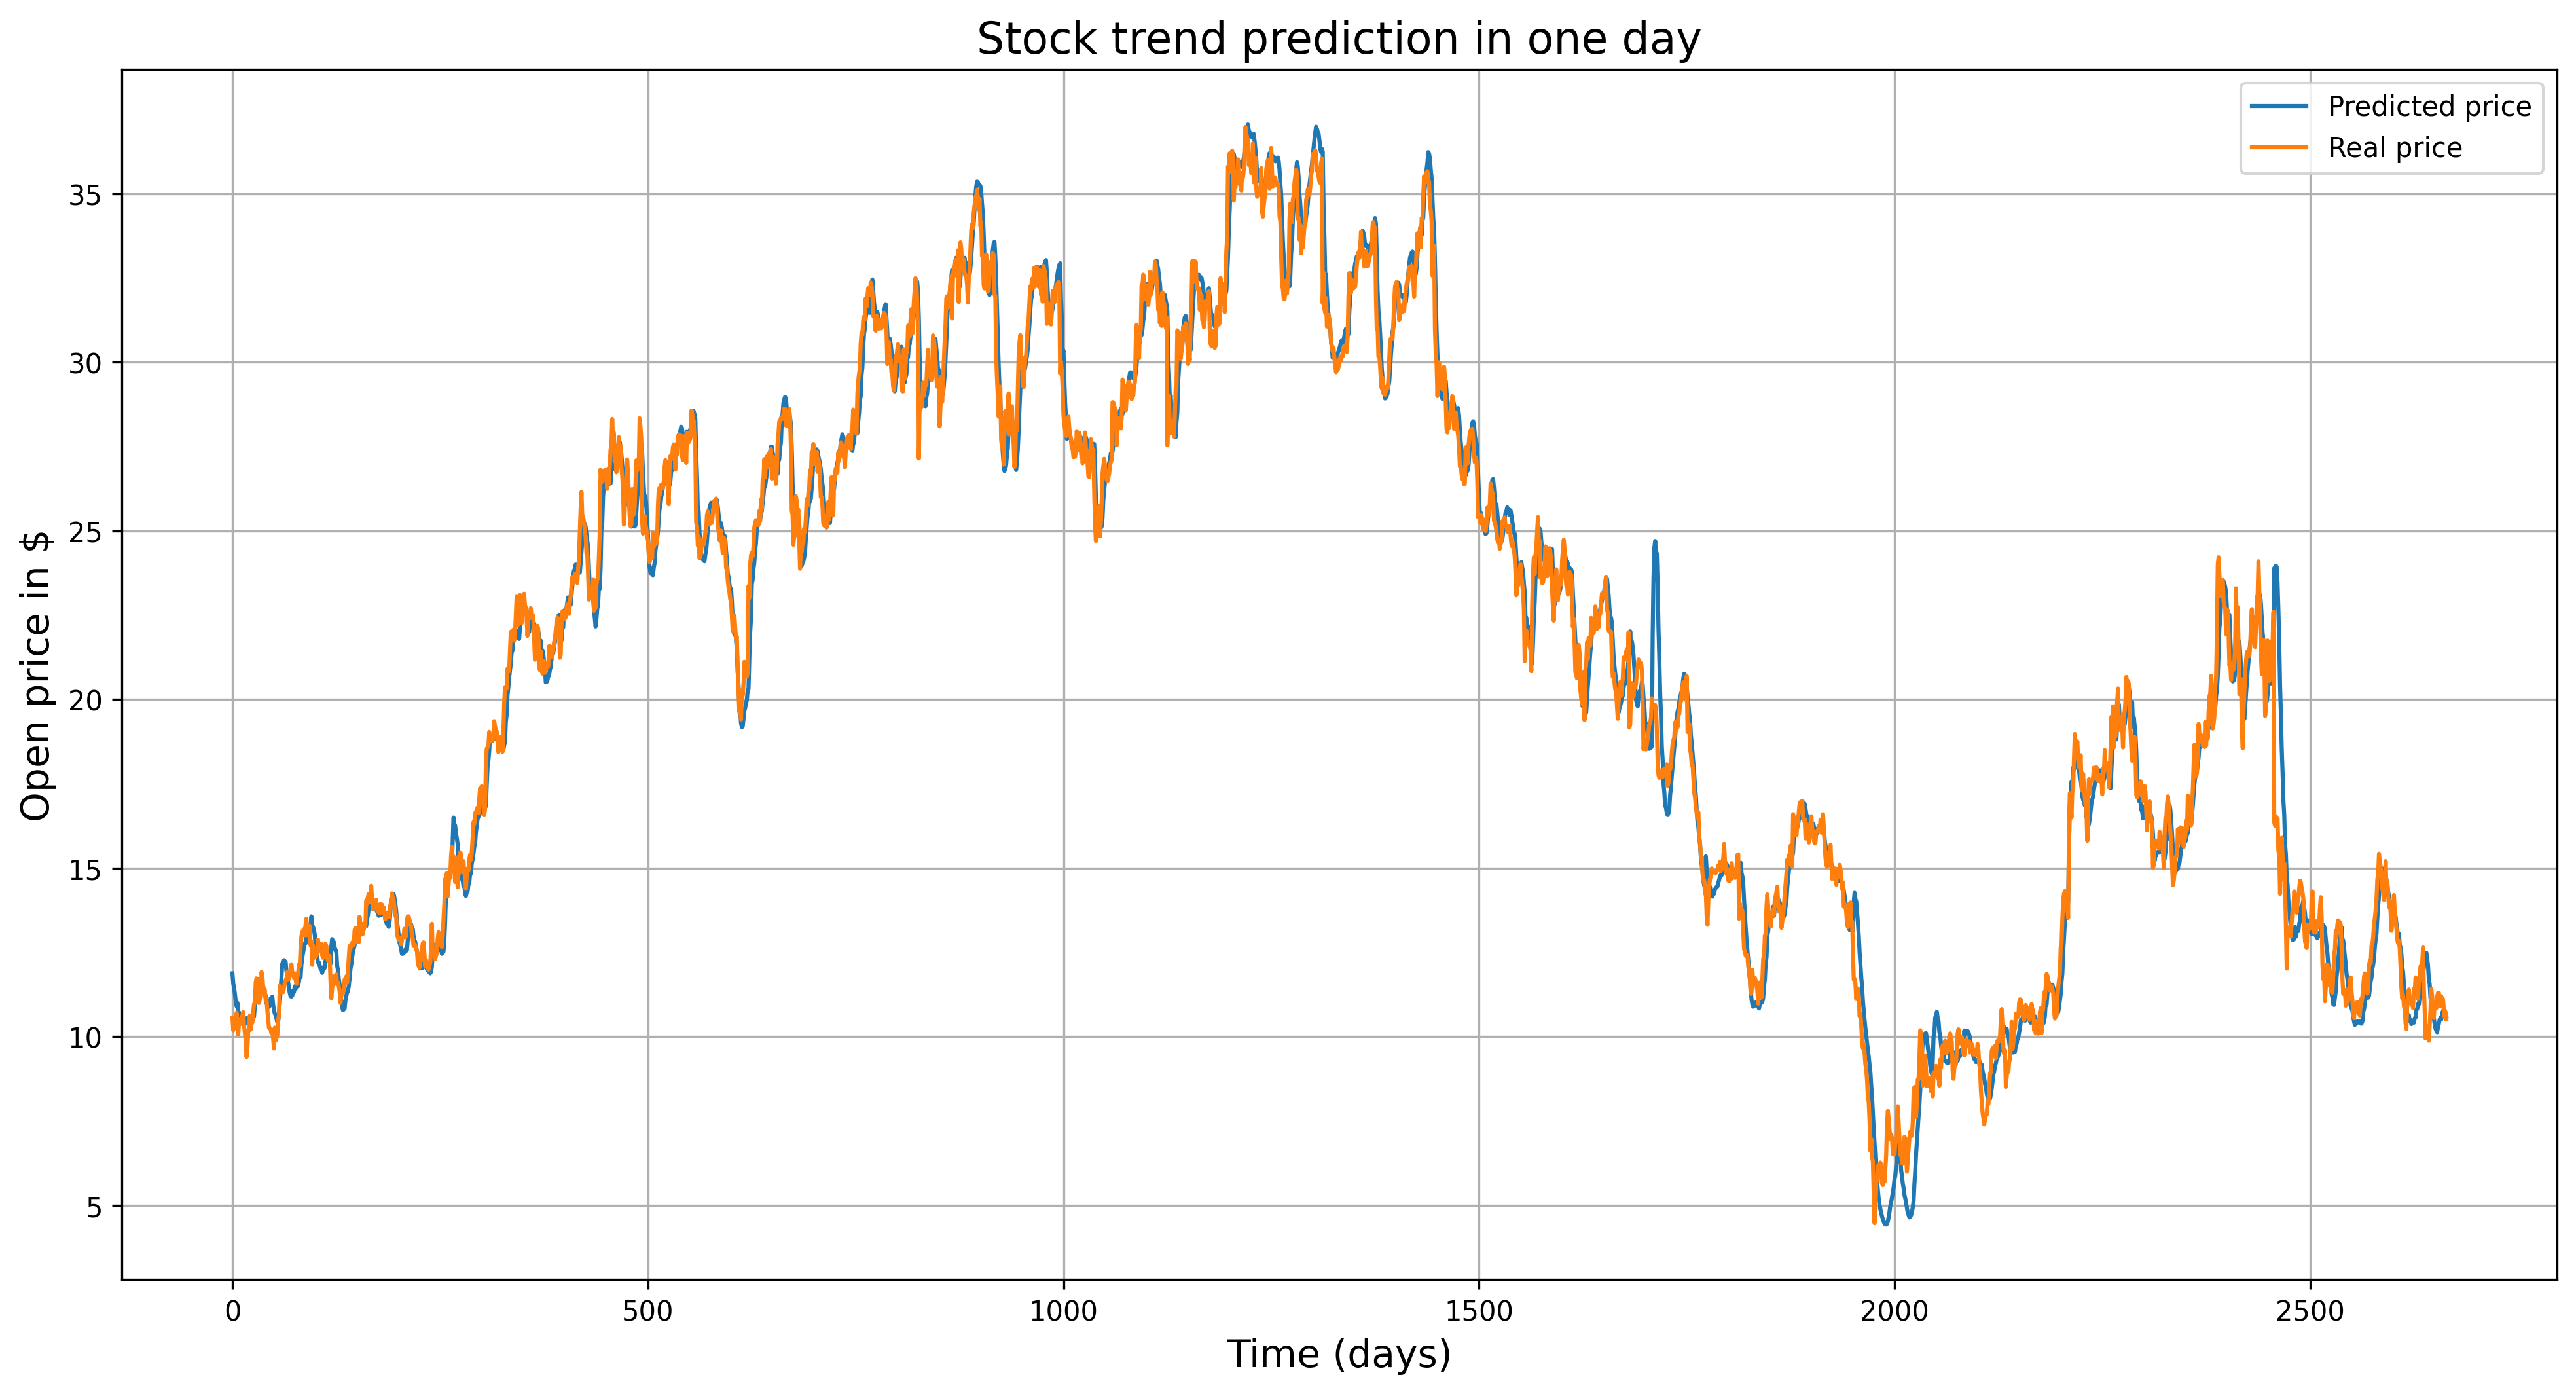

In [ ]:
# Visualize preditec stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

# Task 1.2: Predict day $k^{th}$

# Task 1.3: Predict k day ahead

# Commit and Push to GitHub

In [ ]:
!git config --global user.email "ltquemy@gmail.com"
!git config --global user.name "zk-qmy"
!git config --list

filter.lfs.clean=git-lfs clean -- %f
filter.lfs.smudge=git-lfs smudge -- %f
filter.lfs.process=git-lfs filter-process
filter.lfs.required=true
user.email=ltquemy@gmail.com
user.name=zk-qmy
core.repositoryformatversion=0
core.filemode=true
core.bare=false
core.logallrefupdates=true
remote.origin.url=https://github.com/zk-qmy/dl-stock-prediction.git
remote.origin.fetch=+refs/heads/*:refs/remotes/origin/*
branch.main.remote=origin
branch.main.merge=refs/heads/main


In [ ]:
! git add .
!git commit -m "init nasdag notebook"
!git push origin main  # Replace 'main' with your branch name if different

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address
